In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999

# Данные

Данные орагнизрваны в две таблицы, чтобы сгруппировать отчеты, которые соответствуют и не соответствуют рекомендуемым методам представления данных:
- `Information and Metrics` - содержит данные по участкам с одним зданием и кампусам, где четко определены родительские/дочерние отношения. Большинство свойств перечислено здесь, и данные в хорошей форме.
- `Multi-BBL` - содержит материалы кампуса, в которых родительские/дочерние отношения неясны, обычно потому, что количество зданий, перечисленных в родительском доме, не совпадает с количеством домов детей.

In [361]:
df1 = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')

In [362]:
df2 = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Multi-BBL')

Объеденим таблицы и посмотрим на данные

In [363]:
df = df1.append(df2)

Сразу удалим все данные, где отсутствует наш целевой признак.

In [364]:
df = df[df['ENERGY STAR Score'].notna()]

Посмотрим на пропуски в данных

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25642 entries, 0 to 329
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       25642 non-null  int64         
 1   Property Id                                                 25642 non-null  int64         
 2   Property Name                                               25642 non-null  object        
 3   Parent Property Id                                          970 non-null    object        
 4   Parent Property Name                                        970 non-null    object        
 5   BBL - 10 digits                                             25213 non-null  object        
 6   NYC Borough, Block and Lot (BBL) self-reported              25214 non-null  object        
 7   NYC Building Identificat

## Начальная чистка

Как видим, у нас есть переменные, в которых очень много пропусков (такие как `Propane Use (kBtu)` или `Fuel Oil #1 Use (kBtu)`). Все данные, где меньше половины данных пропуски - просто отбросим.

In [366]:
df_all_cols = df.columns

for col in df_all_cols:
    if sum(df[col].isna()) > df.shape[0]/2:
        df = df.drop(columns=col)

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25642 entries, 0 to 329
Data columns (total 41 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       25642 non-null  int64         
 1   Property Id                                                 25642 non-null  int64         
 2   Property Name                                               25642 non-null  object        
 3   BBL - 10 digits                                             25213 non-null  object        
 4   NYC Borough, Block and Lot (BBL) self-reported              25214 non-null  object        
 5   NYC Building Identification Number (BIN)                    24888 non-null  object        
 6   Address 1 (self-reported)                                   25642 non-null  object        
 7   Postal Code             

Отлично. С большим количеством пропусков остались только столбцы `Water Use (All Water Sources) (kgal)` и `Water Use Intensity (All Water Sources) (gal/ft²)`. Посмотрим как они коррилируют с целевым признаком.

In [368]:
df[['Water Use (All Water Sources) (kgal)', 'Water Use Intensity (All Water Sources) (gal/ft²)', 'ENERGY STAR Score']]

,Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),ENERGY STAR Score
0,3635.5,21.46,90.0
1,102.9,1.09,100.0
2,10762.6,86.10,83.0
3,790.1,15.80,27.0
4,143.0,2.86,99.0
...,...,...,...
325,8723.9,106.91,22.0
326,8121.1,126.39,57.0
327,NaN,NaN,39.0
328,7365.8,122.47,41.0


In [369]:
cols_to_check = ['Water Use (All Water Sources) (kgal)', 
                 'Water Use Intensity (All Water Sources) (gal/ft²)', 
                 'ENERGY STAR Score']

In [370]:
df[cols_to_check].corr()['ENERGY STAR Score'][:]

Water Use (All Water Sources) (kgal)                -0.000871
Water Use Intensity (All Water Sources) (gal/ft²)   -0.004341
ENERGY STAR Score                                    1.000000
Name: ENERGY STAR Score, dtype: float64

Как видим, они совсем не коррелируют, поэтому их можно тоже отбросить.

In [371]:
df = df.drop(columns=['Water Use (All Water Sources) (kgal)', 
                 'Water Use Intensity (All Water Sources) (gal/ft²)'])

Удалим столбцы, где больше половины значений "Not found"

In [372]:
df_all_cols = df.columns

for col in df_all_cols:
    if sum(df[col] == 'Not found') > df.shape[0]/2:
        df = df.drop(columns=col)

Удалим не ревевантные столбцы. Тут воспользуемся здравым смыслом.

In [373]:
df.sample(5)

,Order,Property Id,Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Borough,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,Metered Areas (Energy),ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Generation Date
29388,29681,6283017,"2-02891-0006 (ECW, 1744 Clay)",2028910006.0,2-02891-0006,2009351,1744 Clay,10457,Bronx,46123,Multifamily Housing,Multifamily Housing,Multifamily Housing,46123.0,1920,1,100,Whole Building,33.0,117.1,121.0,79.4,83.1,5.7,0.6,2771343.6,29439.7,889311.9,260642.4,260679.1,222.5,147.2,75.3,2019-02-12
29898,30197,6691154,11 West 25th Street,NaN,NaN,NaN,11 West 25th Street,10010,Manhattan,26504,Office,Office,Office,26504.0,1913,1,95,Whole Building,89.0,67.7,75.7,57.3,65.2,1.6,NaN,NaN,NaN,146057.5,42807.0,42807.0,114.2,101.8,12.4,2019-02-13
19586,19799,6282788,MILLER: 1901 Hennessy Place,2032280009.0,2-03228-0009,2014986,1901 Hennessy Place Bronx,10453,Bronx,51385,Multifamily Housing,Multifamily Housing,Multifamily Housing,51385.0,1930,1,100,Whole Building,1.0,214.7,222.3,155.0,162.1,8.7,1.3,6439505.9,68034.1,1524978.6,446945.6,447762.1,471.2,342.0,129.2,2018-12-04
29133,29423,6692896,215 East 58th Street,1013320010.0,1-01332-0010,1038624,215 East 48th Street,10022,Manhattan,28000,Office,Office,Office,28000.0,1950,1,100,Whole Building,72.0,100.2,98.7,38.4,38.3,9.7,NaN,NaN,NaN,946318.6,277350.1,270257.4,88.7,0.0,88.7,2019-02-09
33999,34331,4403958,"3065 Roberts Ave, 10461",2041760034.0,2-04176-0034,2046271,3065 Roberts Ave,10461,Bronx,57000,Multifamily Housing,Multifamily Housing,Multifamily Housing,57000.0,1929,1,100,Whole Building,69.0,104.4,110.6,80.8,86.6,3.3,0.8,3969657.1,42977.2,635878.9,186365.4,187782.6,264.7,210.8,53.9,2019-02-22


In [374]:
cols_to_drop = ['Order', 'Property Id', 'Property Name', 'BBL - 10 digits',
                'NYC Borough, Block and Lot (BBL) self-reported',
                'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
                'Year Built', 'Metered Areas (Energy)', 'Generation Date', 'Postal Code'
                ]

df = df.drop(columns = cols_to_drop)

In [375]:
df.sample(5)

,Borough,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
30991,Manhattan,43440,Multifamily Housing,Multifamily Housing,Multifamily Housing,43440.0,1,100,39.0,128.0,NaN,103.6,NaN,3.7,0.0,193646.9,1959.9,561462.9,164555.3,162362.2,339.9,292.3,47.6
4956,Queens,53500,Multifamily Housing,Multifamily Housing,Multifamily Housing,53500.0,1,100,100.0,36.7,36.7,13.9,13.9,3.1,0.0,173300.0,1733.0,567963.1,166460.5,166460.5,59.6,9.2,50.4
23907,Queens,128184,Multifamily Housing,Multifamily Housing,Multifamily Housing,128184.0,1,100,51.0,109.6,115.7,70.6,76.5,5.9,0.6,6456099.9,72178.1,2594614.4,760437.9,759501.3,562.7,342.9,219.7
12198,Bronx,91300,K-12 School,K-12 School,K-12 School,91300.0,1,100,95.0,87.7,92.3,60.5,65.0,3.7,0.0,31100.0,311.0,1139880.9,334080.0,334080.0,430.3,329.3,101.1
19366,Bronx,47826,Multifamily Housing,Multifamily Housing,Multifamily Housing,47826.0,1,100,1.0,200.9,202.8,139.7,142.2,9.0,1.1,5198215.6,53345.0,1482677.6,434547.9,429129.0,401.7,276.1,125.6


Остальные пропуски просто удалим

In [376]:
df = df.dropna()

In [377]:
df.sample(3)

,Borough,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
872,Manhattan,571246,Office,Office,Office,571246.0,1,100,89.0,181.6,182.1,68.0,69.0,15.2,0.1,4578257.7,45782.6,29775521.0,8726705.0,8671452.1,3182.9,243.2,2939.7
1256,Manhattan,71118,Multifamily Housing,Multifamily Housing,Multifamily Housing,71118.0,1,100,44.0,128.1,133.7,92.4,98.2,4.3,0.8,5509556.2,59427.6,1059517.0,310526.6,305209.8,386.6,292.6,93.9
18521,Manhattan,65058,Multifamily Housing,Multifamily Housing,Multifamily Housing,65058.0,1,90,33.0,139.5,145.4,101.9,107.7,5.4,0.9,5418166.8,58074.4,1210406.7,354749.9,351986.1,390.3,287.8,102.5


## Немного поработаем с категориальными признаками

Категориальные признаки закодируем

In [378]:
df['Borough'] = df['Borough'].astype('category').cat.codes
df['Primary Property Type - Self Selected'] = \
                    df['Primary Property Type - Self Selected'].astype('category').cat.codes
df['Largest Property Use Type'] = df['Largest Property Use Type'].astype('category').cat.codes

А для признака `List of All Property Use Types at Property` извлечем количество объктов и создадим для него новый признак.

In [379]:
df['List of All Property Use Types at Property'] = \
            df['List of All Property Use Types at Property'].apply(lambda x: len(x.split(',')))

In [380]:
df.sample(3)

,Borough,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
14296,2,71169,13,1,8,71169.0,1,100,29.0,138.4,144.2,101.4,107.5,4.4,0.9,6132929.6,65874.7,1085575.9,318164.1,312162.6,422.0,325.7,96.2
30402,4,42564,13,1,8,42564.0,1,100,100.0,47.2,46.7,20.5,20.4,4.2,0.1,248730.0,2508.4,623964.9,182873.6,180418.4,66.1,13.2,52.8
21208,7,98748,13,1,8,98748.0,1,95,38.0,122.3,127.5,90.1,95.0,4.6,0.8,7332070.9,78141.9,1564691.0,458584.6,458584.6,522.0,389.4,132.5


## Удалим коррелирующие друг с другом признаки

Удалим коррелирующие с целевым признаком

In [381]:
for col in df.drop(columns='ENERGY STAR Score').columns:
    if df["ENERGY STAR Score"].corr(df[col]) > 0.7:
        print(f'{col} - {df["ENERGY STAR Score"].corr(df[col])}')

Как видим, таких нет

Удалим коррелирующие друг с другом признаки

In [382]:
df.corr().style.background_gradient(cmap='coolwarm')

,Borough,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
Borough,1.000000,0.039300,0.021188,0.074279,0.029417,0.039784,0.070279,-0.013655,0.033969,-0.000421,-0.000404,-0.002409,-0.002388,0.069931,-0.004919,-0.003950,-0.003874,0.043911,0.043911,0.044056,0.000729,-0.004119,0.004176
Self-Reported Gross Floor Area (ft²),0.039300,1.000000,-0.015865,0.263574,-0.009354,0.996521,0.156594,-0.020755,0.052749,0.004960,0.005085,0.002946,0.003066,0.062463,-0.001016,0.079276,0.082143,0.648465,0.648465,0.648117,0.094500,0.083480,0.054596
Primary Property Type - Self Selected,0.021188,-0.015865,1.000000,0.055173,0.925455,-0.017507,-0.006617,-0.024990,0.021274,0.023684,0.023441,0.019578,0.019376,0.116602,0.000487,-0.002740,-0.002830,0.006742,0.006742,0.007227,0.009029,-0.003766,0.014472
List of All Property Use Types at Property,0.074279,0.263574,0.055173,1.000000,0.074322,0.241435,0.009491,-0.037210,-0.010806,0.014345,0.014255,0.011125,0.011053,0.122889,0.005669,0.023036,0.023230,0.323657,0.323657,0.324180,0.043695,0.023899,0.036830
Largest Property Use Type,0.029417,-0.009354,0.925455,0.074322,1.000000,-0.012349,-0.011491,-0.037791,0.011802,0.023355,0.023157,0.017981,0.017833,0.179997,-0.000376,-0.003976,-0.004093,0.033999,0.033999,0.034482,0.008011,-0.005005,0.014151
Largest Property Use Type - Gross Floor Area (ft²),0.039784,0.996521,-0.017507,0.241435,-0.012349,1.000000,0.161070,-0.019730,0.056277,0.004596,0.004730,0.002667,0.002794,0.057931,-0.001284,0.078063,0.080913,0.650208,0.650208,0.649814,0.093830,0.082239,0.054721
Number of Buildings,0.070279,0.156594,-0.006617,0.009491,-0.011491,0.161070,1.000000,0.007499,-0.028134,-0.000333,-0.000234,-0.000059,0.000043,-0.010901,0.001292,0.016979,0.017811,0.073436,0.073436,0.073258,0.013488,0.017494,0.003395
Occupancy,-0.013655,-0.020755,-0.024990,-0.037210,-0.037791,-0.019730,0.007499,1.000000,-0.022741,0.001767,0.001691,0.002349,0.002297,-0.019916,0.002908,0.002834,0.002877,-0.027939,-0.027939,-0.028075,-0.003308,0.003259,-0.006783
ENERGY STAR Score,0.033969,0.052749,0.021274,-0.010806,0.011802,0.056277,-0.028134,-0.022741,1.000000,-0.054428,-0.055385,-0.047887,-0.048916,-0.298550,-0.031967,-0.025504,-0.025946,-0.050242,-0.050242,-0.050469,-0.039197,-0.025297,-0.029999
Source EUI (kBtu/ft²),-0.000421,0.004960,0.023684,0.014345,0.023355,0.004596,-0.000333,0.001767,-0.054428,1.000000,0.999603,0.997676,0.997774,0.052504,0.786853,0.661348,0.660260,0.022288,0.022288,0.022271,0.777178,0.660969,0.469169


In [383]:
cols_to_drop = ['Self-Reported Gross Floor Area (ft²)',
                'Largest Property Use Type',
                'Weather Normalized Source EUI (kBtu/ft²)',
                'Site EUI (kBtu/ft²)',
                'Natural Gas Use (kBtu)',
                'Direct GHG Emissions (Metric Tons CO2e)',
                'Source EUI (kBtu/ft²)',
                'Electricity Use - Grid Purchase (kBtu)',
                'Electricity Use - Grid Purchase (kWh)']

In [384]:
df = df.drop(columns = cols_to_drop)

In [385]:
df.corr().style.background_gradient(cmap='coolwarm')

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
Borough,1.000000,0.021188,0.074279,0.039784,0.070279,-0.013655,0.033969,-0.002388,0.069931,-0.004919,-0.003874,0.044056,0.000729,0.004176
Primary Property Type - Self Selected,0.021188,1.000000,0.055173,-0.017507,-0.006617,-0.024990,0.021274,0.019376,0.116602,0.000487,-0.002830,0.007227,0.009029,0.014472
List of All Property Use Types at Property,0.074279,0.055173,1.000000,0.241435,0.009491,-0.037210,-0.010806,0.011053,0.122889,0.005669,0.023230,0.324180,0.043695,0.036830
Largest Property Use Type - Gross Floor Area (ft²),0.039784,-0.017507,0.241435,1.000000,0.161070,-0.019730,0.056277,0.002794,0.057931,-0.001284,0.080913,0.649814,0.093830,0.054721
Number of Buildings,0.070279,-0.006617,0.009491,0.161070,1.000000,0.007499,-0.028134,0.000043,-0.010901,0.001292,0.017811,0.073258,0.013488,0.003395
Occupancy,-0.013655,-0.024990,-0.037210,-0.019730,0.007499,1.000000,-0.022741,0.002297,-0.019916,0.002908,0.002877,-0.028075,-0.003308,-0.006783
ENERGY STAR Score,0.033969,0.021274,-0.010806,0.056277,-0.028134,-0.022741,1.000000,-0.048916,-0.298550,-0.031967,-0.025946,-0.050469,-0.039197,-0.029999
Weather Normalized Site EUI (kBtu/ft²),-0.002388,0.019376,0.011053,0.002794,0.000043,0.002297,-0.048916,1.000000,0.032240,0.821468,0.690020,0.013538,0.775108,0.443210
Weather Normalized Site Electricity Intensity (kWh/ft²),0.069931,0.116602,0.122889,0.057931,-0.010901,-0.019916,-0.298550,0.032240,1.000000,0.021631,0.023418,0.377873,0.033134,0.024174
Weather Normalized Site Natural Gas Intensity (therms/ft²),-0.004919,0.000487,0.005669,-0.001284,0.001292,0.002908,-0.031967,0.821468,0.021631,1.000000,0.840179,0.006774,0.519739,-0.000480


Другое дело

## Разобьем выборку на test и train

In [386]:
from sklearn.model_selection import train_test_split

In [387]:
df = df.reset_index(drop='index')

In [403]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ENERGY STAR Score'),
                                                    df['ENERGY STAR Score'],
                                                    test_size = 0.3)

# Модели

Давайте обучим первую модель, которую потом улучшим.

In [404]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Первая модель

In [405]:
model1 = LinearRegression()

In [406]:
model1.fit(X_train, y_train)

LinearRegression()

In [407]:
y_pred1 = model1.predict(X_test)

In [408]:
mean_squared_error(y_test, y_pred1)

16373.123405948914

In [409]:
mean_absolute_error(y_test, y_pred1)

27.34965617474692

Как видим, метрики получились очень плохими. Давайте поработаем с фичами, чтобы улучшить точность.

## Еще research

Давайте посмотрим на те объекты, на которых предсказание было очень неточным.

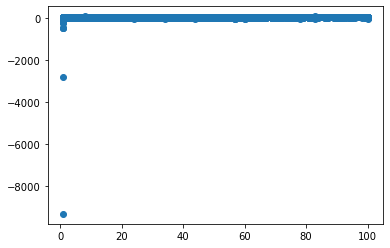

In [410]:
plt.scatter(y_test, y_pred1)
plt.show()

In [411]:
y_test[y_pred1 < -1000]

15625    1.0
12802    1.0
Name: ENERGY STAR Score, dtype: float64

In [412]:
df.loc[[12801,12802,15624,15625], :]

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
12801,3,13,1,39106.0,1,100,15.0,85.6,9.3,0.5,21042.3,364276.4,211.8,106.8
12802,3,13,3,178403.0,1,100,1.0,138766.7,4.3,1387.5,286695182.5,884327.1,1523025.9,249.9
15624,3,13,2,40168.0,1,100,78.0,54.7,7.4,0.3,11886.0,296095.2,148.7,85.6
15625,3,13,1,61056.0,1,100,1.0,206060.1,5.5,2060.4,125800661.8,334090.3,668285.7,97.8


<AxesSubplot:>

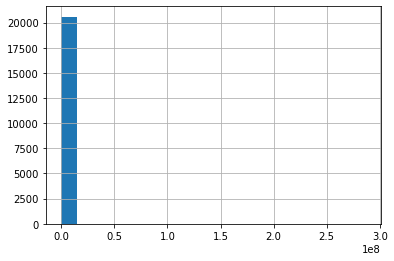

In [257]:
df['Weather Normalized Site Natural Gas Use (therms)'].hist(bins=20)

In [261]:
df[['Weather Normalized Site Natural Gas Use (therms)',
    'Total GHG Emissions (Metric Tons CO2e)',
    'Weather Normalized Site EUI (kBtu/ft²)']].describe()

,Weather Normalized Site Natural Gas Use (therms),Total GHG Emissions (Metric Tons CO2e),Weather Normalized Site EUI (kBtu/ft²)
count,2.058100e+04,2.058100e+04,20581.000000
mean,8.345670e+04,1.054028e+03,136.124999
std,2.234441e+06,1.911701e+04,2121.086752
min,0.000000e+00,0.000000e+00,0.000000
25%,1.085900e+04,2.232000e+02,67.200000
50%,3.495280e+04,3.537000e+02,86.200000
75%,5.991050e+04,6.105000e+02,108.400000
max,2.866952e+08,1.523026e+06,206060.100000


In [413]:
df = df[df['Weather Normalized Site Natural Gas Use (therms)'] < df['Weather Normalized Site Natural Gas Use (therms)'].std()]

In [414]:
df[['Weather Normalized Site Natural Gas Use (therms)',
    'Total GHG Emissions (Metric Tons CO2e)',
    'Weather Normalized Site EUI (kBtu/ft²)']].describe()

,Weather Normalized Site Natural Gas Use (therms),Total GHG Emissions (Metric Tons CO2e),Weather Normalized Site EUI (kBtu/ft²)
count,2.055700e+04,2.055700e+04,20557.000000
mean,5.387308e+04,8.917297e+02,116.562820
std,1.034947e+05,1.502524e+04,1212.024944
min,0.000000e+00,0.000000e+00,0.000000
25%,1.082530e+04,2.230000e+02,67.100000
50%,3.490690e+04,3.533000e+02,86.100000
75%,5.981550e+04,6.087000e+02,108.300000
max,2.192435e+06,1.317762e+06,97164.600000


In [415]:
df = df[df['Weather Normalized Site EUI (kBtu/ft²)'] < df['Weather Normalized Site EUI (kBtu/ft²)'].std()]

In [416]:
df[['Weather Normalized Site Natural Gas Use (therms)',
    'Total GHG Emissions (Metric Tons CO2e)',
    'Weather Normalized Site EUI (kBtu/ft²)']].describe()

,Weather Normalized Site Natural Gas Use (therms),Total GHG Emissions (Metric Tons CO2e),Weather Normalized Site EUI (kBtu/ft²)
count,2.054000e+04,20540.000000,20540.000000
mean,5.371225e+04,638.331952,92.234479
std,1.030240e+05,1246.865028,54.288812
min,0.000000e+00,0.000000,0.000000
25%,1.082998e+04,222.875000,67.100000
50%,3.491375e+04,353.050000,86.100000
75%,5.978120e+04,607.825000,108.200000
max,2.192435e+06,40161.800000,1039.200000


In [417]:
df = df[df['Total GHG Emissions (Metric Tons CO2e)'] < df['Total GHG Emissions (Metric Tons CO2e)'].std()]

## Вторая модель

Еще раз обучим модель и посмотрим на выбросы

In [419]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ENERGY STAR Score'),
                                                    df['ENERGY STAR Score'],
                                                    test_size=0.3)

In [420]:
model2 = LinearRegression()

In [421]:
model2.fit(X_train, y_train)

LinearRegression()

In [422]:
y_pred2 = model2.predict(X_test)

In [423]:
mean_squared_error(y_test, y_pred2)

477.6093231022045

In [424]:
mean_absolute_error(y_test, y_pred2)

17.71323517710896

Отлично, прогресс есть. Посмотрим почему сейчас происходят выбросы

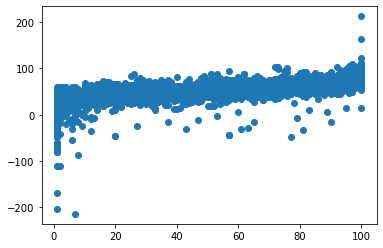

In [425]:
plt.scatter(y_test, y_pred2)
plt.show()

In [428]:
y_test[y_pred2 < -150]

11414    1.0
5222     1.0
10499    7.0
Name: ENERGY STAR Score, dtype: float64

In [429]:
df.loc[[11414,11415,5222,5223,10499, 10498], :]

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
11414,7,13,1,13800.0,1,100,1.0,587.1,22.9,5.0,68339.8,315573.9,467.8,90.7
11415,7,13,1,25000.0,1,100,1.0,287.7,11.0,2.4,60833.8,275059.5,416.3,80.6
5222,7,13,1,15300.0,1,100,1.0,662.5,25.7,5.6,85533.8,393766.9,590.9,118.9
5223,7,13,1,48000.0,1,100,1.0,170.8,6.7,1.4,69125.3,319991.2,477.7,96.2
10499,4,13,1,4838.0,1,100,7.0,691.6,34.8,0.2,928.7,168126.8,233.0,48.9
10498,4,13,1,28233.0,1,100,58.0,69.2,5.3,0.5,14390.0,150475.5,112.7,43.7


In [430]:
model2.coef_

array([ 1.23705365e+00,  1.01325338e+00,  4.17465467e-01,  8.32618664e-05,
       -1.20363982e-01,  9.10513238e-02, -4.45804885e-01,  7.59139327e-02,
        2.77817818e-01, -7.07149150e-05, -8.54978081e-06,  5.11726494e-03,
       -1.14775550e-02])

Как видим, модель очень плохо предсказывает маленькие значения. Давайте удалим значения < 10.

In [431]:
df_cut = df[df['ENERGY STAR Score'] > 10]

## Третья модель

In [468]:
X_train, X_test, y_train, y_test = train_test_split(df_cut.drop(columns='ENERGY STAR Score'),
                                                    df_cut['ENERGY STAR Score'],
                                                    test_size=0.3)

In [471]:
model3 = LinearRegression()

In [472]:
model3.fit(X_train, y_train)

LinearRegression()

In [473]:
y_pred2 = model3.predict(X_test)

In [474]:
mean_squared_error(y_test, y_pred2)

359.0066570341454

In [475]:
mean_absolute_error(y_test, y_pred2)

14.846026157594961

Отлично, эта модель стала примерно в два раза точней, чем наша изначальная модель.

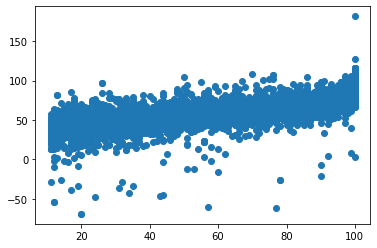

In [476]:
plt.scatter(y_test, y_pred2)
plt.show()

In [477]:
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['predict'] = y_pred2

In [478]:
df_check.sample(12)

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings,Occupancy,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),target,predict
7601,7,13,1,53394.0,1,100,123.0,3.9,1.1,58580.2,207216.3,360.6,63.1,23.0,36.795465
10317,4,13,1,92955.0,1,100,96.9,6.4,0.3,31047.6,595836.0,598.0,174.1,59.0,53.055121
15493,4,13,1,51600.0,1,100,105.0,5.3,0.9,44795.5,275466.8,317.5,79.6,49.0,44.716650
13024,3,13,1,130496.0,1,100,83.7,3.8,0.7,92174.2,499484.3,593.0,143.8,57.0,60.103179
15978,2,13,2,62890.0,1,100,79.7,6.1,0.6,43085.3,450553.2,339.2,129.7,54.0,57.236643
2927,7,13,2,153091.0,3,100,95.4,4.5,0.8,122328.5,693845.9,788.4,207.0,60.0,56.851350
10922,4,13,1,68838.0,1,100,102.9,4.8,0.9,59651.2,327595.2,389.1,95.8,23.0,46.639087
17618,3,13,1,76091.0,1,95,64.6,5.7,0.5,34263.6,436342.8,299.0,126.1,84.0,67.227122
6876,4,9,1,63600.0,0,100,35.4,10.3,0.0,241.0,652799.9,198.8,197.5,78.0,81.032056
6553,2,9,1,133325.0,1,100,79.6,6.5,0.6,76691.7,861599.9,621.8,260.6,56.0,55.212258


Как видим, с маленькими значениями модель все же справляется плохо.